In [34]:
] activate

  Activating project at `~/.julia/environments/v1.9`


In [42]:
using Oceananigans
using Printf

In [43]:
grid = RectilinearGrid(size=(128, 128), x=(-5, 5), z=(-5, 5),
                       topology=(Periodic, Flat, Bounded))

128×1×128 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── Periodic x ∈ [-5.0, 5.0)      regularly spaced with Δx=0.078125
├── Flat y
└── Bounded  z ∈ [-5.0, 5.0]      regularly spaced with Δz=0.078125

In [44]:
shear_flow(x, z, t) = tanh(z)

stratification(x, z, t, p) = p.h * p.Ri * tanh(z / p.h)

U = BackgroundField(shear_flow)

B = BackgroundField(stratification, parameters=(Ri=0.1, h=1/4));

In [ ]:
] status

In [45]:
using CairoMakie

zF = znodes(grid, Face())
zC = znodes(grid, Center())

Ri, h = B.parameters

fig = Figure(size = (850, 450))

ax = Axis(fig[1, 1], xlabel = "U(z)", ylabel = "z", limits=((nothing, nothing), (-5, 5)))
lines!(ax, shear_flow.(0, zC, 0), zC; linewidth = 3)

ax = Axis(fig[1, 2], xlabel = "B(z)", limits=((nothing, nothing), (-5, 5)))
lines!(ax, [stratification(0, z, 0, (Ri=Ri, h=h)) for z in zC], zC; linewidth = 3, color = :red)

ax = Axis(fig[1, 3], xlabel = "Ri(z)", limits=((nothing, nothing), (-5, 5)))
lines!(ax, [Ri * sech(z / h)^2 / sech(z)^2 for z in zF], zF; linewidth = 3, color = :black) # Ri(z)= ∂_z B / (∂_z U)²; derivatives computed by hand

#fig

Lines{Tuple{Vector{Point{2, Float32}}}}

In [46]:
model = NonhydrostaticModel(timestepper = :RungeKutta3,
                              advection = UpwindBiasedFifthOrder(),
                                   grid = grid,
                               coriolis = nothing,
                      background_fields = (u=U, b=B),
                                closure = ScalarDiffusivity(ν=0.2e-4, κ=0.2e-4),
                               buoyancy = BuoyancyTracer(),
                                tracers = :b)

LoadError: MethodError: no method matching shear_flow(::Float64, ::Float64, ::Float64, ::Float64)

[0mClosest candidates are:
[0m  shear_flow(::Any, ::Any, ::Any)
[0m[90m   @[39m [32mMain[39m [90m[4mIn[44]:1[24m[39m


In [47]:
Δt = 0.1 
simulation = Simulation(model, Δt=Δt, stop_iteration=2000, verbose=false)

LoadError: UndefVarError: `model` not defined

In [48]:
using Random, Statistics

u, v, w = model.velocities
b = model.tracers.b
xb, yb, zb = nodes(b)
total_b = Field(b + model.background_fields.tracers.b)

mean_perturbation_kinetic_energy = Field(Average(1/2 * (u^2 + w^2)))

noise(x, z) = 1.e-3*randn()
set!(model, u=noise, w=noise, b=noise)

LoadError: UndefVarError: `model` not defined

In [49]:
simulation.output_writers[:buoyancy] =
    JLD2OutputWriter(model, (b=b, B=total_b),
                     schedule = TimeInterval(1.0),
                     filename = "../output/stratified_shear_data/example.jld2",
                     overwrite_existing = true)

LoadError: UndefVarError: `b` not defined

In [10]:
@info "*** Running a simulation of Kelvin-Helmholtz instability..."
run!(simulation)

[ Info: *** Running a simulation of Kelvin-Helmholtz instability...


In [11]:
@info "Making a neat movie of stratified shear flow..."

filepath = simulation.output_writers[:buoyancy].filepath

B_timeseries = FieldTimeSeries(filepath, "B")

times = B_timeseries.times
t_final = times[end]

n = Observable(1)

Bₙ = @lift interior(B_timeseries, :, 1, :, $n)

fig = Figure(size=(800, 600))

kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xb[1], xb[end]), (-3, 3)), aspect=1,)

title = @lift @sprintf("temperature [°C] at t = %.2f", times[$n])

ax_B = Axis(fig[1, 1]; title = title, kwargs...)

B_lims = (-maximum(abs, interior(B_timeseries, :, 1, :, :)), maximum(abs, interior(B_timeseries, :, 1, :, :)))

hm_B = heatmap!(ax_B, xb, zb, Bₙ; colorrange = B_lims, colormap = :balance)
Colorbar(fig[1, 2], hm_B)

frames = 1:length(times)

record(fig, "../movies/Lecture01_shear_instability_example.mp4", frames, framerate=8) do i
    @info "Plotting frame $i of $(frames[end])..."
    n[] = i
end

[ Info: Making a neat movie of stratified shear flow...
[ Info: Plotting frame 1 of 187...
[ Info: Plotting frame 2 of 187...
[ Info: Plotting frame 3 of 187...
[ Info: Plotting frame 4 of 187...
[ Info: Plotting frame 5 of 187...
[ Info: Plotting frame 6 of 187...
[ Info: Plotting frame 7 of 187...
[ Info: Plotting frame 8 of 187...
[ Info: Plotting frame 9 of 187...
[ Info: Plotting frame 10 of 187...
[ Info: Plotting frame 11 of 187...
[ Info: Plotting frame 12 of 187...
[ Info: Plotting frame 13 of 187...
[ Info: Plotting frame 14 of 187...
[ Info: Plotting frame 15 of 187...
[ Info: Plotting frame 16 of 187...
[ Info: Plotting frame 17 of 187...
[ Info: Plotting frame 18 of 187...
[ Info: Plotting frame 19 of 187...
[ Info: Plotting frame 20 of 187...
[ Info: Plotting frame 21 of 187...
[ Info: Plotting frame 22 of 187...
[ Info: Plotting frame 23 of 187...
[ Info: Plotting frame 24 of 187...
[ Info: Plotting frame 25 of 187...
[ Info: Plotting frame 26 of 187...
[ Info: Plotting 

"../movies/Lecture01_shear_instability_example.mp4"

In [12]:
fig = Figure(size=(900, 600))
kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xb[1], xb[end]), (zb[1], zb[end])), aspect=1,)
ax_B = Axis(fig[1, 1]; title = "temperature [°C] at t=0 minutes", kwargs...)
hm_B = heatmap!(ax_B, xb, zb, interior(B_timeseries, :, 1, :, 1); colorrange = B_lims, colormap = :balance)

ax_B = Axis(fig[1, 2]; title = "temperature [°C] at t=90 minutes", kwargs...)
hm_B = heatmap!(ax_B, xb, zb, interior(B_timeseries, :, 1, :, 90); colorrange = B_lims, colormap = :balance)
lines!(ax_B, [0, 0], [-5, 5], linestyle=:dash, color=:black)

ax_B = Axis(fig[1, 3]; title = "temperature [°C] at t=180 minutes", kwargs...)
hm_B = heatmap!(ax_B, xb, zb, interior(B_timeseries, :, 1, :, 180); colorrange = B_lims, colormap = :balance)

ax_B = Axis(fig[2, 2]; title = "temperature at t=90 minutes", xlabel="temperature [ºC]", ylabel="z [m]", limits=(0.75.*B_lims, (zb[1], zb[end])))
l_B = lines!(ax_B, interior(B_timeseries, 64, 1, :, 90), zb, label="x=0 m")

Colorbar(fig[1, 4], hm_B)
leg = axislegend(ax_B, position=:lt)
save("../figures/Lecture01_shear_instability_snapshots.png", fig)
#fig

l_B = lines!(ax_B, mean(interior(B_timeseries, :, 1, :, 90), dims=(1))[1,:], zb, label="zonal average")
delete!(leg)
axislegend(ax_B, position=:lt)
save("../figures/Lecture01_shear_instability_snapshots_mean.png", fig)
#fig

CairoMakie.Screen{IMAGE}


In [13]:
using Statistics
Bₙ = interior(B_timeseries, :, 1, :, 186)
b_mean = mean(Bₙ, dims=(1))[1,:]

lines(b_mean, zb)

print(size(Bₙ))



(128, 128)

#### Now let's try to calculate $z_{*}$ using the heaviside step function

We first need to define some xo and zo

If we choose the values where xo=-2.5 and zo=-1 we need to figure out which index in the xb array and zb array refer to these values. 

In [14]:
indexxo = findfirst(x -> x == -2.5390625, xb)
indexzo = findfirst(z -> z == -1.0546875, zb)

println("The value ∼ -2.5 is found at index $indexxo")
println("The value ∼ -1 is found at index $indexzo")

The value ∼ -2.5 is found at index 32
The value ∼ -1 is found at index 51


### Now we know $x_o = 32$ and $z_o = 51$ and we can use this to calculate the Heaviside

$ H(\rho(x,t)-\rho(x_o, t)) = \left\{
\begin{array}{ll}
        0, \rho(x,t)\leq\rho(x_o, t)\\
        1, \rho(x,t)>\rho(x_o,t)\\
\end{array}
\right.$

#### Since our model outputs buoyancy values rather than density and we know $b \propto -\rho$ We can multiply both sides of the inequality by -1. 

$ H(b(x_o,t)-b(x, t)) = \left\{
\begin{array}{ll}
        0, b(x,t)\geq b(x_o, t)\\
        1, b(x,t)<b(x_o,t)\\
\end{array}
\right.$

In [15]:
xo=32
zo=51

#Calculate the Heaviside

H = (Bₙ .>= Bₙ[zo,xo])

128×128 BitMatrix:
 0  0  1  1  1  1  1  1  1  1  0  0  0  …  1  1  1  1  1  1  1  1  1  1  1  1
 0  0  1  1  1  1  1  1  1  1  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  1  1  1  1  1  1  1  1  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  1  1  1  1  1  1  1  1  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  1  1  1  1  1  1  1  1  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  1  1  1  1  1  1  1  1  1  0  0  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  0  0     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  0     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  0  0  0  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  0  0  0  0  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  0  0  0  0  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  0  0  0  0  1  1  1  1  1  1  1     1 

In [ ]:
#A = (zb[end]-zb[1]) * (xb[end]-xb[1])

#A = Lx * Ly
V = A * yb[1]

zₛ  = (H * V)/A

### Make a plot of $z_{*}$ in the x versus buoyancy in the x

### $z_{*}$ vs $B(x)$



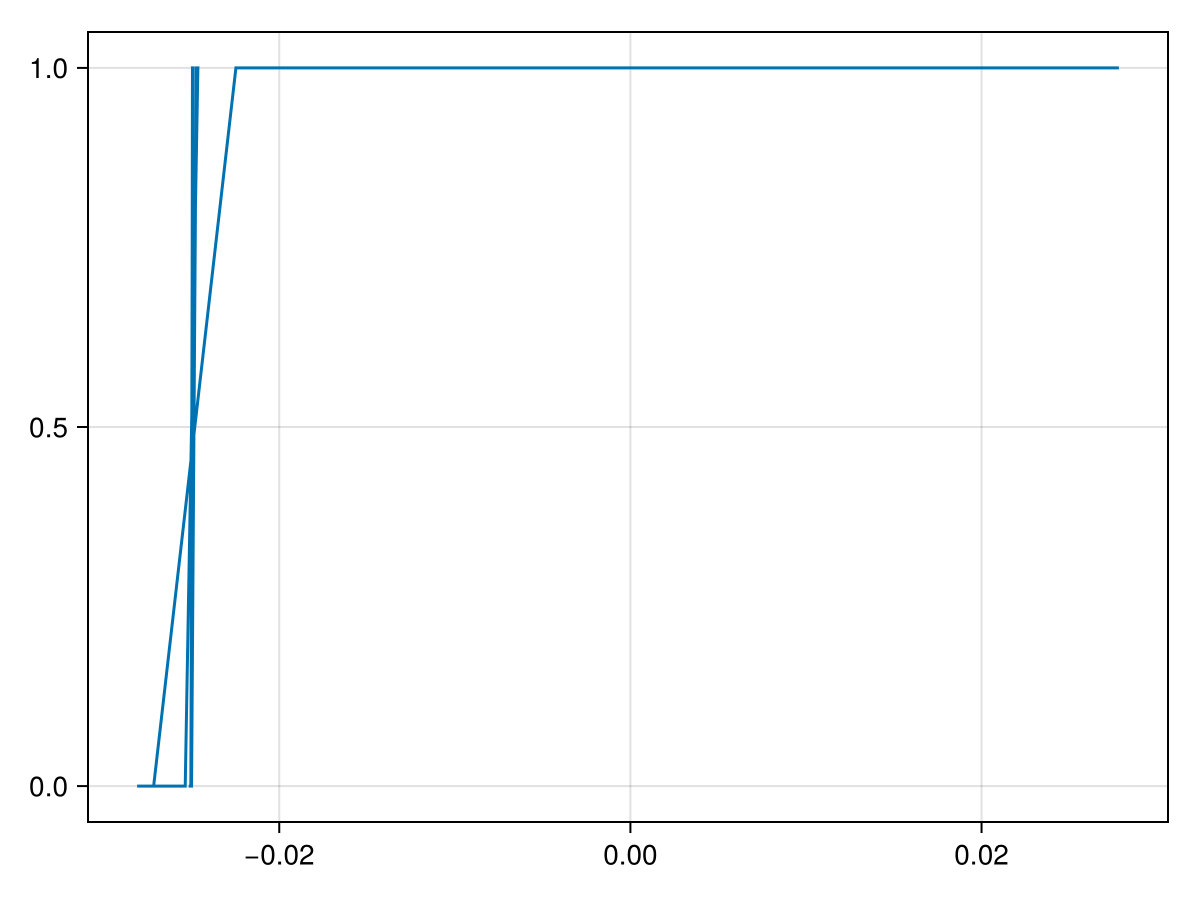

In [18]:
lines(Bₙ[1,:], zₛ[1,:])



In [ ]:
#lines(Bₙ[1,:], H[1,:])